In [1]:
import sys
from copy import copy, deepcopy
import sympy as sp
import itertools
import math

from sympy.physics.vector import Point, ReferenceFrame
from sympy.physics.vector import Vector, outer, dynamicsymbols
from sympy.physics.vector import kinematic_equations, vprint
from sympy.physics.vector.functions import time_derivative
from sympy.physics.mechanics import LagrangesMethod, RigidBody, Lagrangian, msubs
from sympy.physics.mechanics.linearize import Linearizer

from sympy.utilities.codegen import codegen
from sympy.printing.cxxcode import cxxcode
from sympy.printing.pycode import pycode, PythonCodePrinter, NumPyPrinter

from IPython.display import display, Latex

sp.init_printing(use_latex='mathjax')

import casadi as cs
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

print("Loaded python modules.")

Loaded python modules.


In [2]:
a, b, c, d, e, f, g, h = sp.symbols("a,b,c,d,e,f,g,h")
p = [a, b, c, d, e, f, g, h]
x_0, x_f = sp.symbols("X_0,x_f")
t = sp.symbols("t")

In [3]:
x_0 = 0
x_end = 4
t_end = 2

In [4]:
z_0 = sum([t**i * p_i for i, p_i in enumerate(p)])
display(z_0)
print(sp.latex(z_0))

             2      3      4      5      6      7
a + b⋅t + c⋅t  + d⋅t  + e⋅t  + f⋅t  + g⋅t  + h⋅t 

a + b t + c t^{2} + d t^{3} + e t^{4} + f t^{5} + g t^{6} + h t^{7}


In [5]:
z_1 = sp.diff(z_0, t)
display(z_1)
print(sp.latex(z_1))

                 2        3        4        5        6
b + 2⋅c⋅t + 3⋅d⋅t  + 4⋅e⋅t  + 5⋅f⋅t  + 6⋅g⋅t  + 7⋅h⋅t 

b + 2 c t + 3 d t^{2} + 4 e t^{3} + 5 f t^{4} + 6 g t^{5} + 7 h t^{6}


In [6]:
z_2 = sp.diff(z_1, t)
display(z_2)
print(sp.latex(z_2))

                    2         3         4         5
2⋅c + 6⋅d⋅t + 12⋅e⋅t  + 20⋅f⋅t  + 30⋅g⋅t  + 42⋅h⋅t 

2 c + 6 d t + 12 e t^{2} + 20 f t^{3} + 30 g t^{4} + 42 h t^{5}


In [7]:
z_3 = sp.diff(z_2, t)
display(z_3)
print(sp.latex(z_3))

                     2          3          4
6⋅d + 24⋅e⋅t + 60⋅f⋅t  + 120⋅g⋅t  + 210⋅h⋅t 

6 d + 24 e t + 60 f t^{2} + 120 g t^{3} + 210 h t^{4}


In [8]:
z_i = sp.Matrix([
    z_0.subs(t, 0),
    z_1.subs(t, 0),
    z_2.subs(t, 0),
    z_3.subs(t, 0),
    z_0.subs(t, t_end),
    z_1.subs(t, t_end),
    z_2.subs(t, t_end),
    z_3.subs(t, t_end),
])
datamatrix = z_i.jacobian(p)
display(datamatrix)

⎡1  0  0  0   0    0    0    0  ⎤
⎢                               ⎥
⎢0  1  0  0   0    0    0    0  ⎥
⎢                               ⎥
⎢0  0  2  0   0    0    0    0  ⎥
⎢                               ⎥
⎢0  0  0  6   0    0    0    0  ⎥
⎢                               ⎥
⎢1  2  4  8   16  32   64   128 ⎥
⎢                               ⎥
⎢0  1  4  12  32  80   192  448 ⎥
⎢                               ⎥
⎢0  0  2  12  48  160  480  1344⎥
⎢                               ⎥
⎣0  0  0  6   48  240  960  3360⎦

In [9]:
constraintvector = sp.Matrix([x_0, 0, 0, 0, x_end, 0, 0, 0])
display(constraintvector)

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢4⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

In [10]:
params = datamatrix.inv()@constraintvector
display(params)

⎡  0  ⎤
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢35/4 ⎥
⎢     ⎥
⎢-21/2⎥
⎢     ⎥
⎢35/8 ⎥
⎢     ⎥
⎣-5/8 ⎦

In [11]:
z_sol = z_0
for i, p_i in enumerate(p):
    z_sol = z_sol.subs(p_i, params[i])
display(z_sol)

     7       6       5       4
  5⋅t    35⋅t    21⋅t    35⋅t 
- ──── + ───── - ───── + ─────
   8       8       2       4  

In [12]:
n = t_end * 50
t_i = np.linspace(0, t_end, n)
x_i = np.array([float(z_sol.subs(t, t_current)) for t_current in t_i])

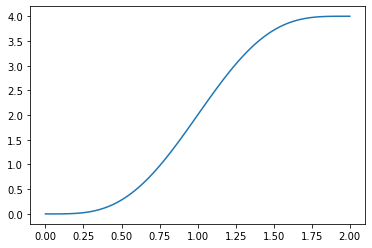

In [13]:
plt.plot(t_i, x_i)

In [14]:
rate = 50


def get_ti(t_end):
    n = rate * t_end
    return np.linspace(0, t_end, n)


def get_feedforward_position(x_0, x_end, t_end):
    constraintvector = sp.Matrix([x_0, 0, 0, 0, x_end, 0, 0, 0])
    params = datamatrix.inv()@constraintvector
    z_sol = z_0
    for i, p_i in enumerate(p):
        z_sol = z_sol.subs(p_i, params[i])
    n = t_end * rate
    t_i = np.linspace(0, t_end, n)
    x_i = np.array([(z_sol.subs(t, t_current)).evalf() for t_current in t_i])
    return x_i


def get_feedforward_velocity(x_0, x_end, t_end):
    constraintvector = sp.Matrix([x_0, 0, 0, 0, x_end, 0, 0, 0])
    params = datamatrix.inv()@constraintvector
    z_sol = z_1
    for i, p_i in enumerate(p):
        z_sol = z_sol.subs(p_i, params[i])
    n = t_end * rate
    t_i = np.linspace(0, t_end, n)
    x_i = np.array([(z_sol.subs(t, t_current)).evalf() for t_current in t_i])
    return x_i


def get_feedforward_acceleration(x_0, x_end, t_end):
    constraintvector = sp.Matrix([x_0, 0, 0, 0, x_end, 0, 0, 0])
    params = datamatrix.inv()@constraintvector
    z_sol = z_2
    for i, p_i in enumerate(p):
        z_sol = z_sol.subs(p_i, params[i])
    n = t_end * rate
    t_i = np.linspace(0, t_end, n)
    x_i = np.array([(z_sol.subs(t, t_current)).evalf() for t_current in t_i])
    return x_i


m = 7.5 + 0.296
J = 0.099 + 1.17e-4


def get_feedforward_input(x_0, x_end, y_0, y_end, theta_0, theta_end, t_end):
    
    n = t_end * rate
    t_i = np.linspace(0, t_end, n)
    
    theta_i = get_feedforward_position(theta_0, theta_end, t_end)
    x_i_2 = get_feedforward_acceleration(x_0, x_end, t_end)
    y_i_2 = get_feedforward_acceleration(y_0, y_end, t_end)
    theta_i_2 = get_feedforward_acceleration(theta_0, theta_end, t_end)
    
    f_x = [m * (math.cos(theta_i[i])*x_i_2[i] + math.sin(theta_i[i])*y_i_2[i]) for i in range(n)]
    f_y = [m * (-math.sin(theta_i[i])*x_i_2[i] + math.cos(theta_i[i])*y_i_2[i]) for i in range(n)]
    torque = [J * theta_i_2[i] for i in range(n)]
    
    f_x = np.array(f_x)
    f_y = np.array(f_y)
    torque = np.array(torque)
    
    return f_x, f_y, torque
    
        

In [15]:
x_0 = -1.40
y_0 = -0.50
theta_0 = 0
x_end = 0
y_end = 0.50
theta_end = -np.pi
t_end = 10

In [16]:
z_i = sp.Matrix([
    z_0.subs(t, 0),
    z_1.subs(t, 0),
    z_2.subs(t, 0),
    z_3.subs(t, 0),
    z_0.subs(t, t_end),
    z_1.subs(t, t_end),
    z_2.subs(t, t_end),
    z_3.subs(t, t_end),
])
datamatrix = z_i.jacobian(p)

In [17]:
t_i = get_ti(t_end)
x_i = get_feedforward_position(x_0, x_end, t_end)
y_i = get_feedforward_position(y_0, y_end, t_end)
theta_i = get_feedforward_position(theta_0, theta_end, t_end)

In [18]:
vx_i = get_feedforward_velocity(x_0, x_end, t_end)
vy_i = get_feedforward_velocity(y_0, y_end, t_end)
vtheta_i = get_feedforward_velocity(theta_0, theta_end, t_end)

In [19]:
f_x, f_y, torque = get_feedforward_input(x_0, x_end, y_0, y_end, theta_0, theta_end, t_end)

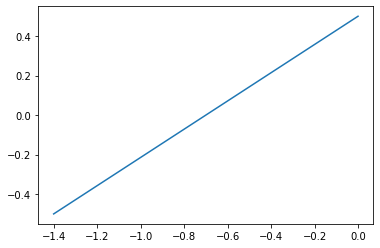

In [20]:
plt.plot(x_i, y_i)

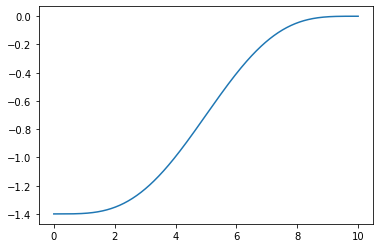

In [21]:
plt.plot(t_i, x_i)

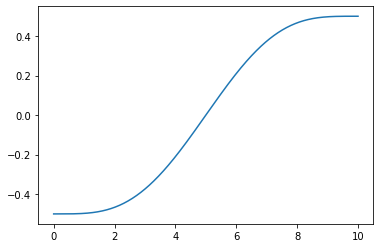

In [22]:
plt.plot(t_i, y_i)

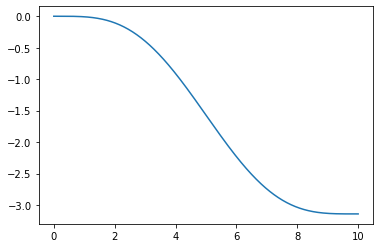

In [23]:
plt.plot(t_i, theta_i)

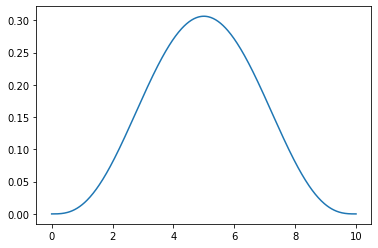

In [24]:
plt.plot(t_i, vx_i)

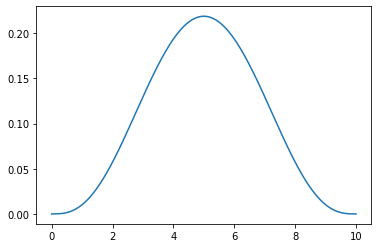

In [25]:
plt.plot(t_i, vy_i)

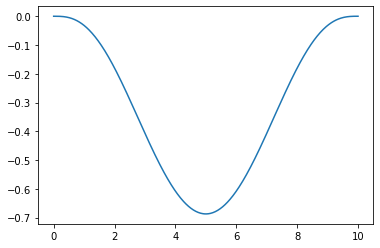

In [26]:
plt.plot(t_i, vtheta_i)

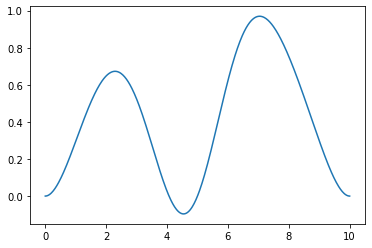

In [27]:
plt.plot(t_i, f_x)

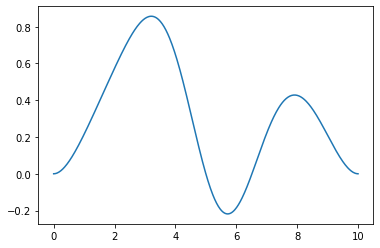

In [28]:
plt.plot(t_i, f_y)

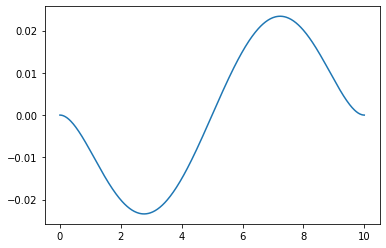

In [29]:
plt.plot(t_i, torque)